# Generating predictions

With the saved models from the previos notebook, all it is ready to generate requested predictions

This procedure is developed for batch procesing, it means that a file of requested dates for predictions should be given at the begining, and the file also should contain a predetermined fields name

This notebook generates an output retrieving the given file filled with predictions

In [35]:
#LOADS LIBRARIES
import os
import sys
import warnings
warnings.simplefilter('ignore')
import pickle
import json
#import dill as pickle

import numpy as np
import pandas as pd
import math

import time 
import datetime
from dateutil.relativedelta import relativedelta

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
#sns.reset_orig
#matplotlib.rc_file_defaults()

In [37]:
# Defines the storage directories

INPUT_DIR = os.getcwd() + '/data/'
OUTPUT_DIR = os.getcwd() + '/results/'
PREDS_DIR = os.getcwd() + '/predictions/'

In [4]:
#List of files inner the input folder to choose the file to be predicted

def get_information(directory):
    file_list = []
    for i in os.listdir(directory):
        a = os.stat(os.path.join(directory,i))
        file_list.append([i,time.ctime(a.st_atime),time.ctime(a.st_ctime)]) #[file,most_recent_access,created]

    return file_list

ls_filesinfo = get_information(INPUT_DIR)

df_files = pd.DataFrame(ls_filesinfo)
df_files['modification_date'] = df_files[1].apply(lambda x: datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %Y"))
df_files = df_files.sort_values(['modification_date'],ascending=[False]).reset_index(drop=True)
df_files


,0,1,2,modification_date
0,dataset_predict.csv,Mon Jul 11 16:22:36 2022,Sat Jul 9 18:26:53 2022,2022-07-11 16:22:36
1,dataset_train.csv,Mon Jul 11 16:22:36 2022,Sat Jul 9 18:26:53 2022,2022-07-11 16:22:36


In [5]:
#Importing the PREDICTION dataset

FILE_NAME = 'dataset_predict.csv'
df_input_02 = pd.read_csv(INPUT_DIR + FILE_NAME, encoding='latin-1', sep=',', dtype='str')
#df_input_02['set_description'] = '2_PREDICTION'

print(df_input_02.shape)
print(df_input_02)

(2304, 3)
                 date q_predicted Store
0      1/10/2022 0:00           0     1
1      1/10/2022 0:00           0     5
2      1/10/2022 0:00           0     9
3      1/10/2022 0:30           0     1
4      1/10/2022 0:30           0     5
...               ...         ...   ...
2299  1/25/2022 23:00           0     5
2300  1/25/2022 23:00           0     9
2301  1/25/2022 23:30           0     1
2302  1/25/2022 23:30           0     5
2303  1/25/2022 23:30           0     9

[2304 rows x 3 columns]


In [6]:
#Formats the fields according to expected estruture for replicating the model

df_input_02['Store'] = df_input_02['Store'].astype('float')
df_input_02['q_predicted'] = df_input_02['q_predicted'].astype('float')

df_input_02

,date,q_predicted,Store
0,1/10/2022 0:00,0.0,1.0
1,1/10/2022 0:00,0.0,5.0
2,1/10/2022 0:00,0.0,9.0
3,1/10/2022 0:30,0.0,1.0
4,1/10/2022 0:30,0.0,5.0
...,...,...,...
2299,1/25/2022 23:00,0.0,5.0
2300,1/25/2022 23:00,0.0,9.0
2301,1/25/2022 23:30,0.0,1.0
2302,1/25/2022 23:30,0.0,5.0


In [7]:
#FIXING DATE VARIABLES

df_input = df_input_02.copy()
D_DATEVARS = ['date']


def validdate(x,v):
    
    try:
        x1 = x[v].split('/')
    except:
        x1 = None
        
    y1 = None
        
    try:
        
        month = int(x1[0])
        day = int(x1[1])
        yearhour = x1[2].split(' ')
        year = int(yearhour[0])
        hourmins = yearhour[1].split(':')
        hour = int(hourmins[0])
        mins = int(hourmins[1])
        
        y1 = datetime.datetime(year ,month , day, hour, mins)
        
    except:
        y1 = None

    return y1


for v in D_DATEVARS:
    
    DF_DATE = df_input.apply(lambda x: validdate(x,v),axis=1)
    DF_DATE = pd.DataFrame(pd.to_datetime(DF_DATE, errors='coerce'))
    
    DS_INPUT = df_input.drop(columns=[v])
    df_input[v] = DF_DATE
    
    print('Variable transformed: ' + str(v)) 

    
df_input_03 = df_input.copy()
del(df_input)

Variable transformed: date


In [8]:
df_input_03

,date,q_predicted,Store
0,2022-01-10 00:00:00,0.0,1.0
1,2022-01-10 00:00:00,0.0,5.0
2,2022-01-10 00:00:00,0.0,9.0
3,2022-01-10 00:30:00,0.0,1.0
4,2022-01-10 00:30:00,0.0,5.0
...,...,...,...
2299,2022-01-25 23:00:00,0.0,5.0
2300,2022-01-25 23:00:00,0.0,9.0
2301,2022-01-25 23:30:00,0.0,1.0
2302,2022-01-25 23:30:00,0.0,5.0


In [9]:
#Sort the data by the consecutive date

df_analysis = df_input_03.sort_values(['date','Store']).reset_index(drop=True)
df_analysis['date2'] = df_analysis['date']
df_analysis

,date,q_predicted,Store,date2
0,2022-01-10 00:00:00,0.0,1.0,2022-01-10 00:00:00
1,2022-01-10 00:00:00,0.0,5.0,2022-01-10 00:00:00
2,2022-01-10 00:00:00,0.0,9.0,2022-01-10 00:00:00
3,2022-01-10 00:30:00,0.0,1.0,2022-01-10 00:30:00
4,2022-01-10 00:30:00,0.0,5.0,2022-01-10 00:30:00
...,...,...,...,...
2299,2022-01-25 23:00:00,0.0,5.0,2022-01-25 23:00:00
2300,2022-01-25 23:00:00,0.0,9.0,2022-01-25 23:00:00
2301,2022-01-25 23:30:00,0.0,1.0,2022-01-25 23:30:00
2302,2022-01-25 23:30:00,0.0,5.0,2022-01-25 23:30:00


(768, 3)
1.0
2022-01-10 00:00:00
2022-01-25 23:30:00
count    768.000000
mean      41.220016
std       23.880970
min        5.958393
25%       18.045438
50%       41.027546
75%       58.980318
max       84.556540
Name: q_predicted, dtype: float64


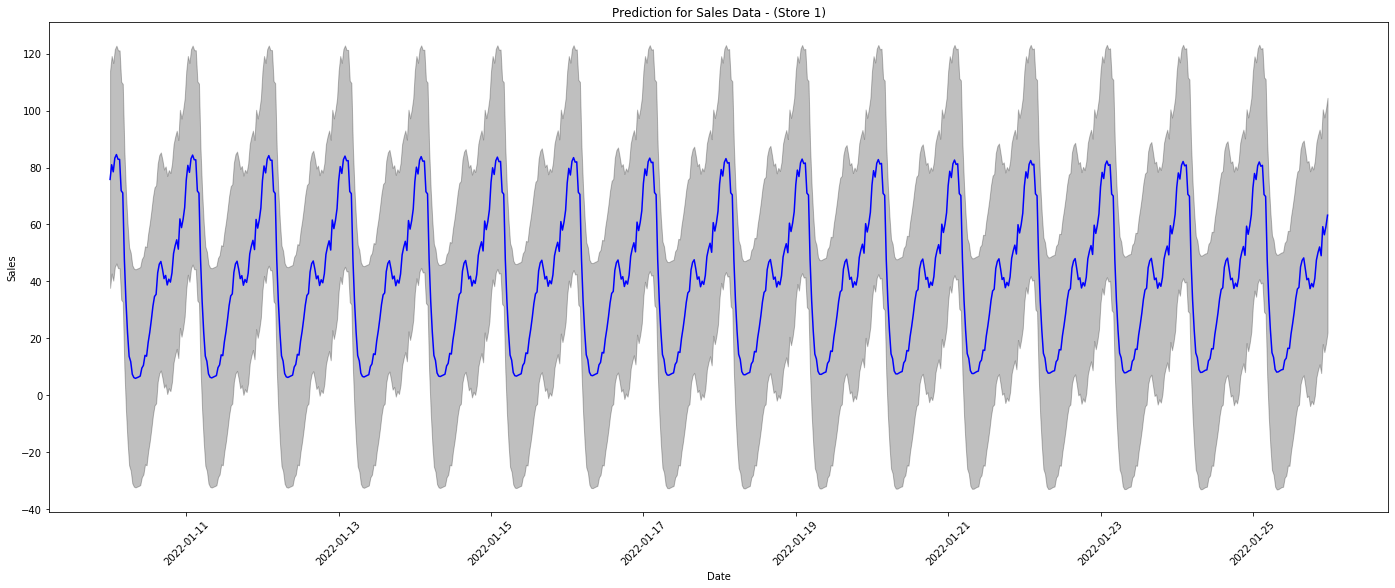

(768, 3)
5.0
2022-01-10 00:00:00
2022-01-25 23:30:00
count    768.000000
mean      54.875159
std       29.919527
min        7.695126
25%       25.986997
50%       62.916100
75%       84.200266
max       99.573606
Name: q_predicted, dtype: float64


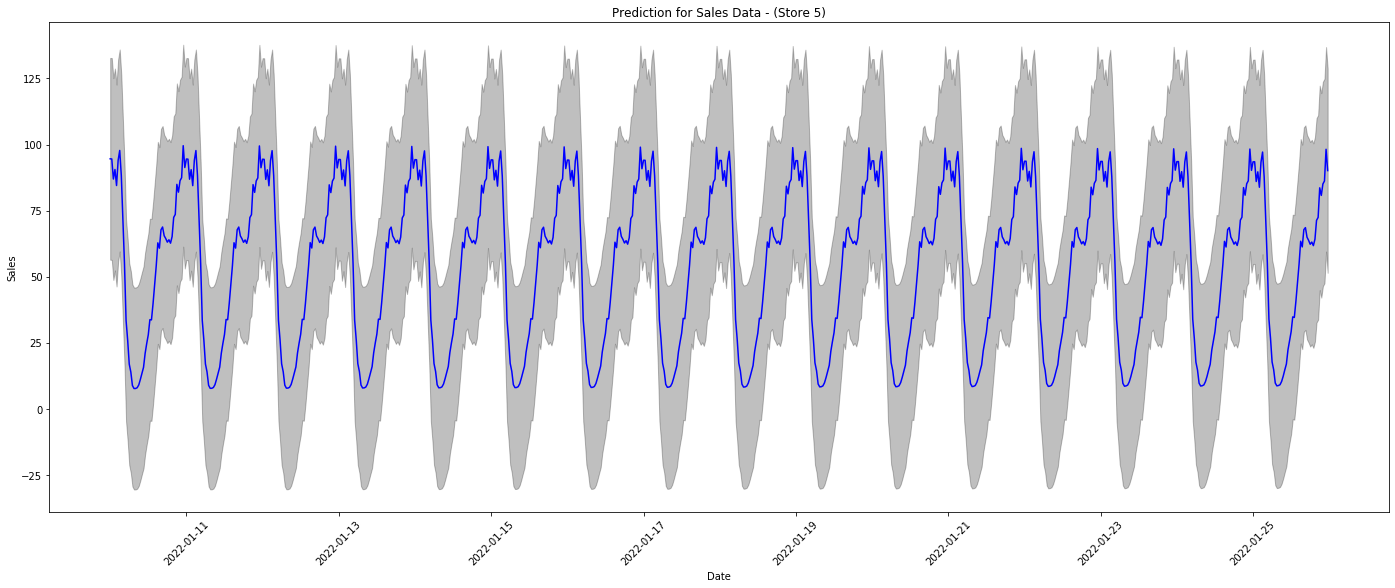

(768, 3)
9.0
2022-01-10 00:00:00
2022-01-25 23:30:00
count    768.000000
mean      23.965365
std       13.607646
min        2.801894
25%        9.975707
50%       27.342076
75%       34.568571
max       44.642993
Name: q_predicted, dtype: float64


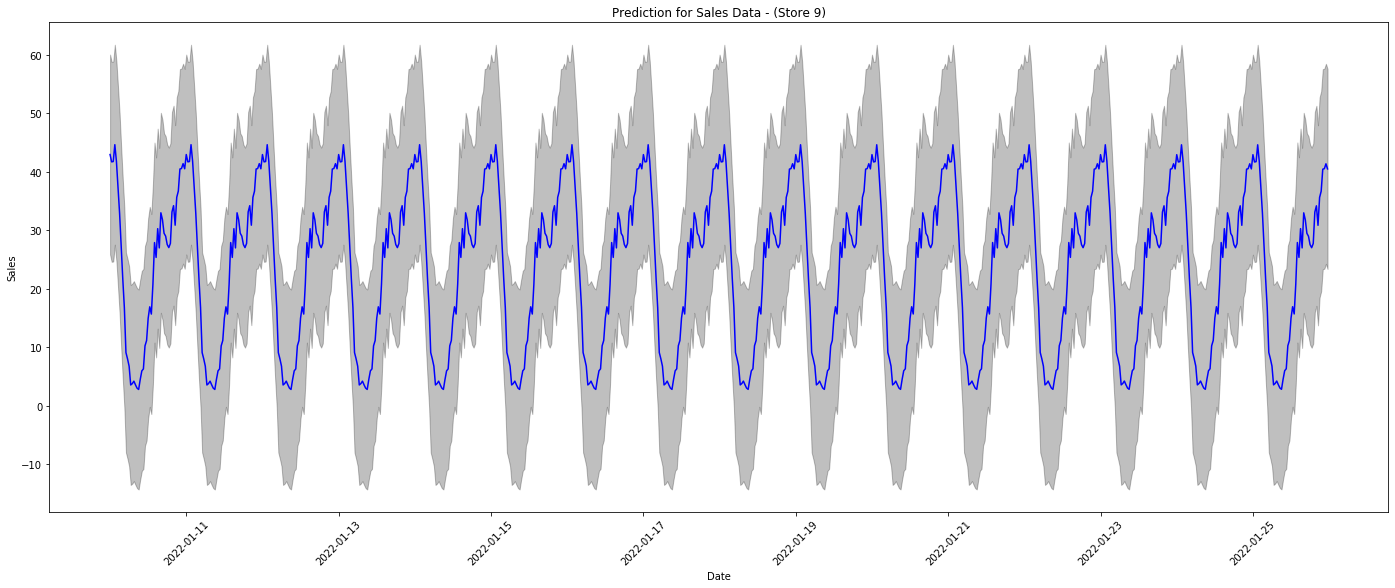

In [12]:
#Loop to generate prediction of all the stores

ls_stores = ['store1','store5','store9']

for ss in ls_stores:


    #Taking appart the stores, because each of one of them have its ouwn time-series

    seleted_segment = ss

    if seleted_segment == 'store1':
        df_store = df_analysis[df_analysis['Store']==1].copy()
    if seleted_segment == 'store5':
        df_store = df_analysis[df_analysis['Store']==5].copy()
    if seleted_segment == 'store9':
        df_store = df_analysis[df_analysis['Store']==9].copy()


    df_store.set_index('date2', inplace=True)

    max_store = max(df_store['Store'])
    min_date = min(df_store['date'])
    max_date = max(df_store['date'])

    print(df_store.shape)
    print(max_store)
    print(min_date)
    print(max_date)
    
    
    
    #Loads the sales time series model 

    if seleted_segment == 'store1':
        results = pickle.load(open( OUTPUT_DIR + 'store1_sales_model.pkl', 'rb'))

    if seleted_segment == 'store5':
        results = pickle.load(open( OUTPUT_DIR + 'store5_sales_model.pkl', 'rb'))

    if seleted_segment == 'store9':
        results = pickle.load(open( OUTPUT_DIR + 'store9_sales_model.pkl', 'rb'))

    print(results)
    
    

    #Generates predictions
    
    pred_uc = results.get_forecast(steps=max_date)
    pred_ci = pred_uc.conf_int()
    pred_ci = pred_ci.loc[df_store.index.tolist()]
    
    df_store['q_predicted'] = pred_uc.predicted_mean
    df_store

    prediction_decription = df_store['q_predicted'].describe()
    print(prediction_decription)
    
    
    
    #Graphical representation of predictions
    if seleted_segment == 'store1':
        
        f, ax = plt.subplots(figsize=(24,9))
        plt.plot(df_store['q_predicted'], color = "blue")
        plt.ylabel('Sales')
        plt.xlabel('Date')
        plt.xticks(rotation=45)
        plt.title("Prediction for Sales Data - (Store 1)")

        ax.fill_between(pred_ci.index,
                            pred_ci.iloc[:, 0],
                            pred_ci.iloc[:, 1], color='k', alpha=.25)

        plt.savefig(PREDS_DIR + 'Predictions_store1.png')
        plt.show()
        
    if seleted_segment == 'store5':
        
        f, ax = plt.subplots(figsize=(24,9))
        plt.plot(df_store['q_predicted'], color = "blue")
        plt.ylabel('Sales')
        plt.xlabel('Date')
        plt.xticks(rotation=45)
        plt.title("Prediction for Sales Data - (Store 5)")

        ax.fill_between(pred_ci.index,
                            pred_ci.iloc[:, 0],
                            pred_ci.iloc[:, 1], color='k', alpha=.25)

        plt.savefig(PREDS_DIR + 'Predictions_store5.png')
        plt.show()
        
    if seleted_segment == 'store9':
        
        f, ax = plt.subplots(figsize=(24,9))
        plt.plot(df_store['q_predicted'], color = "blue")
        plt.ylabel('Sales')
        plt.xlabel('Date')
        plt.xticks(rotation=45)
        plt.title("Prediction for Sales Data - (Store 9)")

        ax.fill_between(pred_ci.index,
                            pred_ci.iloc[:, 0],
                            pred_ci.iloc[:, 1], color='k', alpha=.25)

        plt.savefig(PREDS_DIR + 'Predictions_store9.png')
        plt.show()
        
    
    #Appending results
    
    if ss==ls_stores[0]:
        df_store_01 = df_store.copy()
    else:
        df_store_01 = df_store_01.append(df_store)
        


In [13]:
df_store_01 = df_store_01.sort_values(['date','Store']).reset_index(drop=True)
df_store_01

,date,q_predicted,Store
0,2022-01-10 00:00:00,75.829313,1.0
1,2022-01-10 00:00:00,94.608857,5.0
2,2022-01-10 00:00:00,42.958037,9.0
3,2022-01-10 00:30:00,80.983572,1.0
4,2022-01-10 00:30:00,94.548722,5.0
...,...,...,...
2299,2022-01-25 23:00:00,98.212211,5.0
2300,2022-01-25 23:00:00,41.375777,9.0
2301,2022-01-25 23:30:00,63.261501,1.0
2302,2022-01-25 23:30:00,90.155666,5.0


In [32]:
#Summary table of interes variable in front of segments
df_stores_summary = df_store_01.groupby(['Store'] ).agg(
        min_date = ('date','min'),
        max_date = ('date','max'),
        observations = ('date','count'),
        min_sales = ('q_predicted','min'),
        max_sales = ('q_predicted','max'),
        avg_sales = ('q_predicted', 'mean'),
        std_sales = ('q_predicted', 'std'),
    )

df_stores_summary = df_stores_summary.reset_index()
df_stores_summary['min_date'] = df_stores_summary['min_date'].astype('str')
df_stores_summary['max_date'] = df_stores_summary['max_date'].astype('str')
df_stores_summary

,Store,min_date,max_date,observations,min_sales,max_sales,avg_sales,std_sales
0,1.0,2022-01-10,2022-01-25 23:30:00,768,5.958393,84.556540,41.220016,23.880970
1,5.0,2022-01-10,2022-01-25 23:30:00,768,7.695126,99.573606,54.875159,29.919527
2,9.0,2022-01-10,2022-01-25 23:30:00,768,2.801894,44.642993,23.965365,13.607646


In [22]:
#SYNCS DATES TO INDEX THE OUTPUT
now = datetime.datetime.now()

IDX_FECHAHORA = "{:04d}".format(now.year) + "{:02d}".format(now.month) +  "{:02d}".format(now.day) + "{:02d}".format(now.hour) + "{:02d}".format(now.minute) + "{:02d}".format(now.second)

print(IDX_FECHAHORA)


#Attach a datetime variable with the prediction datetime
#its a good practice refer the moment of a given stimation
df_store_01['prediction_datetime'] = now

#Generates the name of the output file with the prediction response
OUTPUT_NAME1 = FILE_NAME.split('.')[0] + '_' + IDX_FECHAHORA
OUTPUT_NAME1



20220712131503


'dataset_predict_20220712131503'

In [33]:
#Export the predictions output

df_store_01.to_csv(PREDS_DIR + OUTPUT_NAME1 + '.csv', encoding='Latin-1', index=False, sep=',')

df_stores_summary.to_json(PREDS_DIR + 'prediction_summary.json',
                            orient='records', 
                            #date_format=None, 
                            double_precision=2, 
                            force_ascii=True, 
                            #date_unit='ms', 
                            default_handler=None, lines=False, 
                            compression='infer', index=True)


        
print(df_store_01.shape)

(2304, 4)


In [34]:
!pip freeze > requirements.txt